# 5.5. How well are doing and can we do better?

## Loading the data: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import pathlib
data_dir = pathlib.Path('chest_xray')

In [3]:
image_count = len(list(data_dir.glob('*/*/*.jpeg')))
image_count

5856

In [4]:
CLASS_NAMES = np.array(list(set([item.name for item in data_dir.glob('*/*') if item.name.upper() == item.name])))
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [5]:
import os

# more info: https://www.tensorflow.org/tutorials/load_data/images

BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)
AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return 1 if parts[-2] == 'PNEUMONIA' else 0
def decode_img(img):
    # convert the compressed string to a 3D tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def get_dataset(path):
    list_ds = tf.data.Dataset.list_files(os.path.join(str(data_dir), path, '*/*'))
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = prepare_for_training(labeled_ds)

    return ds

In [6]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(np.squeeze(image_batch[n]))
        plt.title('Pneumonia' if label_batch[n] else 'Normal')
        plt.axis('off')

(16,) [1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1]


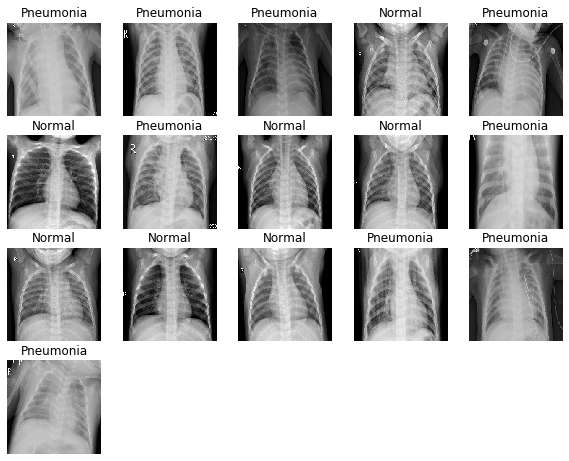

In [7]:
train_ds = get_dataset('train')
image_batch, label_batch = next(iter(train_ds))
print(label_batch.shape, label_batch.numpy())
show_batch(image_batch.numpy(), label_batch.numpy())

## Base model

In [8]:
# https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

In [9]:
#image_3chan_batch = np.repeat(image_batch, 3, -1)
#image_3chan_batch.shape

In [10]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


## Our own top layers

In [11]:
base_model.trainable = False

In [12]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(16, 1280)


In [14]:
fc_layer = tf.keras.layers.Dense(512)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(fc_layer(feature_batch_average))
print(prediction_batch.shape)

(16, 1)


In [15]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    fc_layer,
    prediction_layer
])

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 2,914,369
Trainable params: 656,385
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
val_ds = get_dataset('val')
loss_val, accuracy_val = model.evaluate(val_ds)

1/1 [==============================] - 1s 1s/step - loss: 1.2566 - accuracy: 0.5000


In [19]:
test_ds = get_dataset('test')
loss_test, accuracy_test = model.evaluate(test_ds)

39/39 [==============================] - 9s 240ms/step - loss: 1.7049 - accuracy: 0.3750


In [20]:
epochs = 10
model.fit(train_ds,
          epochs=epochs,
          validation_data=val_ds,
          verbose=1)

Epoch 1/10
326/326 [==============================] - 112s 344ms/step - loss: 0.2000 - accuracy: 0.9181 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
326/326 [==============================] - 92s 283ms/step - loss: 0.1465 - accuracy: 0.9411 - val_loss: 1.0820 - val_accuracy: 0.5000
Epoch 3/10
326/326 [==============================] - 93s 284ms/step - loss: 0.1541 - accuracy: 0.9394 - val_loss: 2.6174 - val_accuracy: 0.5000
Epoch 4/10
326/326 [==============================] - 93s 285ms/step - loss: 0.1430 - accuracy: 0.9434 - val_loss: 3.1527 - val_accuracy: 0.5000
Epoch 5/10
326/326 [==============================] - 93s 285ms/step - loss: 0.1294 - accuracy: 0.9492 - val_loss: 2.6876 - val_accuracy: 0.5000
Epoch 6/10
326/326 [==============================] - 93s 287ms/step - loss: 0.1332 - accuracy: 0.9465 - val_loss: 2.5203 - val_accuracy: 0.5000
Epoch 7/10
326/326 [==============================] - 93s 287ms/step - loss: 0.1254 - accuracy: 0.9521 - val_loss: 1.8666

In [22]:
loss_val, accuracy_val = model.evaluate(val_ds)

1/1 [==============================] - 0s 180ms/step - loss: 2.5879 - accuracy: 0.5000


In [23]:
loss_test, accuracy_test = model.evaluate(test_ds)

39/39 [==============================] - 7s 175ms/step - loss: 2.3348 - accuracy: 0.6250
